In [1]:
# General Stuff:
import numpy as np
import pandas as pd

# Our Stuff:
from models.AutoRecBase import AutoRecBase
from models.VarAutoRec import VarAutoRec
from models.MF import MF


from scripts.get_data import download_2_data_sets, ratings_to_train_test
from scripts.get_2_other_data import get_2_other_datasets, secondary_to_train_test
from utils.evaluate import evaluate_model
from utils.loading_utils import load_model, save_model

import torch
from torch import nn
import pytorch_lightning as pl

# Visualization Stuff
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 240)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# AutoRec - AutoEncoders Meet Collaborative Filtering - PyTorch

<a id="toc"></a>
## Table of Content
1. [Introduction](#introduction)
1. [Conclusions](#conclusions)

<a id="introduction"></a>

## Introduction

In this notebook we will review a collaborative filtering approach using autoencoders, as suggested by Sedhain et al, in their 2015 paper "AutoRec: Autoencoders Meet Collaborative Filtering".

We will then introduce several improvements and asses them.

[Table of content](#toc)

In [2]:
is_default_dataset = True
if is_default_dataset:
    download_2_data_sets()
else:
    get_2_other_datasets()

In [3]:
if is_default_dataset:
    train_loader, val_loader = ratings_to_train_test(1,0, 1,10)
else:
    train_loader, val_loader = secondary_to_train_test(1,0, 1,10)

In [4]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

Launching TensorBoard...

Go to:  [TensorBoard](http://localhost:6006)

In [9]:
models_dict = {} # (model,ephoc,lr): loss
models_state = {} # (model,ephoc,lr): model.state_dict()
models = [
    # AutoRecBase,
    # VarAutoRec,
    MF]
lrs = [0.0005,0.001,0.002,0.004]
activations = [nn.PReLU, nn.Sigmoid]

From the original paper:

In [10]:
latent_dims = [10, 20, 40, 80, 100, 200, 300, 400, 500]
lambdas = [0.001, 0.01, 0.1, 1, 100, 1000]

In [11]:
should_train = True
model_paths = []
if should_train:
    for model_class in models:
        for activation in activations:
            for lr in lrs:
                for latent in latent_dims:
                    for λ in lambdas:
                        model = model_class(number_of_items=3706,
                                            hidden_size=latent,
                                            activation_function_1=activation,
                                            activation_function_2=activation,
                                            loss=nn.MSELoss(reduction='none'),
                                            λ=λ,
                                            lr=lr)
                        # training
                        trainer = pl.Trainer(gpus=0, max_epochs=10)
                        trainer.fit(model,train_loader, val_loader)

                        model_path = save_model(model_class=model_class,
                                   trainer=trainer,
                                   activation=activation,
                                   hidden_size=latent,
                                   lr=lr,
                                   λ=λ,
                                   is_default_dataset=is_default_dataset)
                        model_paths.append(model_path)
                        break
                    break
                break
            break
        break
print(model_paths)

TypeError: __init__() got an unexpected keyword argument 'number_of_items'

In [7]:
models_eval_dict = {}
Ks = [5, 10]
i = 0

for model_class in models:
    for activation in activations:
        for lr in lrs:
            for latent in latent_dims:
                for λ in lambdas:
                    model = load_model(model_class=model_class,
                                       activation=activation,
                                       hidden_size=latent,
                                       lr=lr,
                                       λ=λ,
                                       is_default_dataset=is_default_dataset)
                    for K in Ks:
                        (hits, ndcgs, mrrs) = evaluate_model(model, test_loader=val_loader, K=K)
                        models_eval_dict[f"row_{i}"] = [type(model).__name__, activation, latent, λ, lr, K, "HR", np.mean(hits)]
                        models_eval_dict[f"row_{i+1}"] = [type(model).__name__, activation, latent, λ, lr, K, "NDCG",np.mean(ndcgs)]
                        models_eval_dict[f"row_{i+2}"] = [type(model).__name__, activation, latent, λ, lr, K, "MRR",np.mean(mrrs)]
                        i += 3
                        break
                    break
                break
            break
        break
    break

VarAutoRec(
  (encoder): Linear(in_features=3706, out_features=10, bias=True)
  (act_1): PReLU(num_parameters=1)
  (decoder): Linear(in_features=10, out_features=3706, bias=True)
  (act_2): PReLU(num_parameters=1)
  (loss_func): MSELoss()
  (log_var_layer): Linear(in_features=10, out_features=2, bias=True)
  (mean_layer): Linear(in_features=10, out_features=2, bias=True)
  (bridge_layer): Linear(in_features=2, out_features=10, bias=True)
)
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
T

In [17]:
for x, y, m in val_loader:
    print(x[:,0])
    break
model(x)[:,0]

tensor([5., 3., 3., 3., 3., 4., 3., 4., 5., 5.])


tensor([4.4945, 4.4197, 4.3290, 4.3288, 4.3873, 4.4994, 4.4064, 4.5491, 4.4138,
        4.9536], grad_fn=<SelectBackward0>)

In [8]:
columns = ["model", "activation", "latent_dim", "lambda", "lr","topk","metric","score"]
eval_df = pd.DataFrame.from_dict(models_eval_dict, orient='index', columns=columns)
eval_df

,model,activation,latent_dim,lambda,lr,topk,metric,score
row_0,VarAutoRec,<class 'torch.nn.modules.activation.PReLU'>,10,0.001,0.0005,5,HR,0.001250
row_1,VarAutoRec,<class 'torch.nn.modules.activation.PReLU'>,10,0.001,0.0005,5,NDCG,0.000751
row_2,VarAutoRec,<class 'torch.nn.modules.activation.PReLU'>,10,0.001,0.0005,5,MRR,0.000589


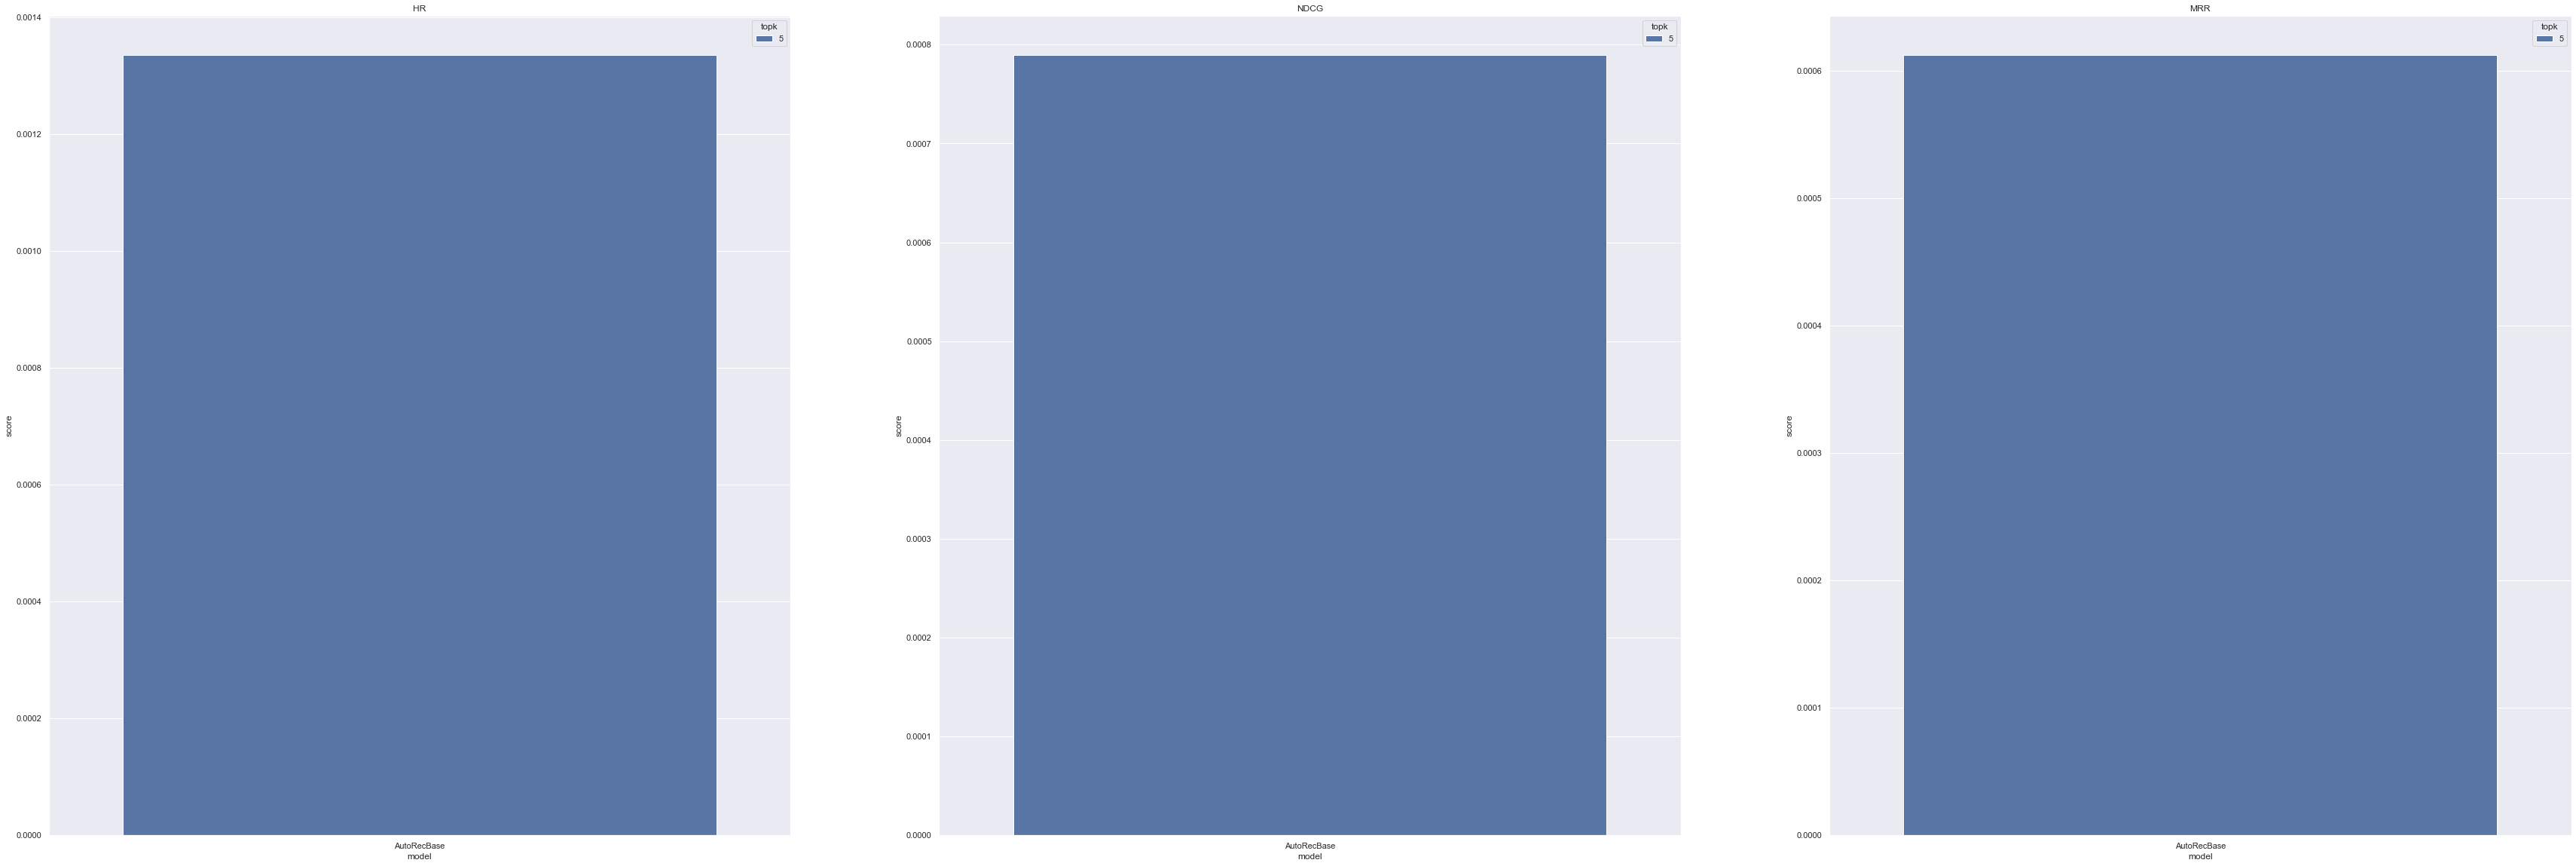

In [15]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(60, 20)

for i, metric in enumerate(['HR', 'NDCG', 'MRR']):
    sns.barplot(data=eval_df[eval_df["metric"] == metric], x="model", y="score", hue="topk", ax=axs[i], orient='v').set(title=metric)